In [39]:
import json
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
projectId = "judini-python-main"
folder_path = "../../test_files/"
nodes_path = f"{folder_path}/{projectId}/nodes.json"
links_path = f"{folder_path}/{projectId}/links.json"






In [40]:
# Function to read JSON files
def read_json_graph(file_path):
    with open(file_path, 'r',encoding="utf8") as file:
        return json.load(file)
def save_json_graph(data, file_path):
    with open(file_path, 'w') as file:
        json.dump(data, file, indent=4)
# Function to construct graph from nodes and links
def construct_graph_from_json(nodes, links):
    G = nx.DiGraph()
    for node in nodes:
        G.add_node(node['id'], **node)
    for link in links:
        G.add_edge(link['source'], link['target'], **link)
    return G

def graph_to_csv(name='codebase'):
    nodes = pd.read_json(nodes_path)
    print(len(nodes))
    nodes['full_name'] = nodes['id']
    edges = pd.read_json(links_path)
    new_nodes = pd.DataFrame({
    "full_name": nodes["id"],
    "type": nodes["type"]})
    
    new_nodes.to_csv(f'nodes_{name}.csv', index=False)
    edges.to_csv(f'edges_{name}.csv', index=False)


In [41]:
# Read nodes and links from JSON files

nodes = read_json_graph(nodes_path)

links = read_json_graph(links_path)
graph_to_csv("vicuna")

G = construct_graph_from_json(nodes, links)

degree_dict = dict(G.degree())

# Subgraphs for "defines" and "calls"
G_nodes = nx.DiGraph((u, v, d) for u, v, d in G.edges(data=True) if ':' in u and ':' in v)
G_files = nx.DiGraph((u, v, d) for u, v, d in G.edges(data=True) if ':' not in u)

G_node_defines = nx.DiGraph((u, v, d) for u, v, d in G.edges(data=True) if d['label'] == 'defines' and ':' in u and ':' in v)
G_node_calls = nx.DiGraph((u, v, d) for u, v, d in G.edges(data=True) if d['label'] == 'calls' and ':' in u and ':' in v)
G_files_defines = nx.DiGraph((u, v, d) for u, v, d in G.edges(data=True) if d['label'] == 'defines' and ':' not in u and ":" not in v)
G_files_calls = nx.DiGraph((u, v, d) for u, v, d in G.edges(data=True) if d['label'] == 'calls' and ':' not in u and ":" not in v)

def calculate_centrality_measures(G):
    degree = nx.degree_centrality(G)
    betweenness = nx.betweenness_centrality(G)
    closeness = nx.closeness_centrality(G)
    pagerank = nx.pagerank(G)
    hubs, authorities = nx.hits(G)
    eigenvector = nx.eigenvector_centrality(G,10000)
    
    return {
        'degree': degree,
        'betweenness': betweenness,
        'closeness': closeness,
        'pagerank': pagerank,
        'hubs': hubs,
        'authorities': authorities,
        'eigenvector': eigenvector
    }

def calculate_in_out_degrees(G):
    indegree = nx.in_degree_centrality(G)
    outdegree = nx.out_degree_centrality(G)
    
    return {
        'indegree': indegree,
        'outdegree': outdegree
    }

def create_dataframe(centrality_measures, in_out_degrees_defines, in_out_degrees_calls, label):
    data = {
        'degree': centrality_measures['degree'],
        'indegree_' + label + '_defines': in_out_degrees_defines['indegree'],
        'outdegree_' + label + '_defines': in_out_degrees_defines['outdegree'],
        'indegree_' + label + '_calls': in_out_degrees_calls['indegree'],
        'outdegree_' + label + '_calls': in_out_degrees_calls['outdegree'],
        'betweenness': centrality_measures['betweenness'],
        'closeness': centrality_measures['closeness'],
        'pagerank': centrality_measures['pagerank'],
        'hubs': centrality_measures['hubs'],
        'authorities': centrality_measures['authorities'],
        'eigenvector': centrality_measures['eigenvector']
    }
    
    df = pd.DataFrame(data)
    return df


# Calculate centrality measures
centrality_measures_nodes = calculate_centrality_measures(G_nodes)
centrality_measures_files = calculate_centrality_measures(G_files)

# Calculate in-degree and out-degree
in_out_degrees_node_defines = calculate_in_out_degrees(G_node_defines)
in_out_degrees_node_calls = calculate_in_out_degrees(G_node_calls)
in_out_degrees_files_defines = calculate_in_out_degrees(G_files_defines)
in_out_degrees_files_calls = calculate_in_out_degrees(G_files_calls)

# Create dataframes
df_nodes = create_dataframe(centrality_measures_nodes, in_out_degrees_node_defines, in_out_degrees_node_calls, 'nodes')
df_files = create_dataframe(centrality_measures_files, in_out_degrees_files_defines, in_out_degrees_files_calls, 'files')


df_nodes.index.name = 'Node'
df_files.index.name = 'Node'
# Set the 'NodeID' column as the new index
#df.set_index('NodeID', inplace=True)

# Normalize the centrality measures
df_nodes = (df_nodes - df_nodes.min()) / (df_nodes.max() - df_nodes.min())
df_files = (df_files - df_files.min()) / (df_files.max() - df_files.min())


# Sum the normalized centrality
df_nodes['combined_score'] = df_nodes.sum(axis=1)
df_files["combined_score"] = df_files.sum(axis=1)

#Separate



# Sort the nodes and files by the combined score
most_important_nodes = df_nodes.sort_values(by='degree', ascending=False)
most_important_files = df_files.sort_values(by='combined_score', ascending=False)
#print('Most Important Nodes:', most_important_nodes)

most_important_nodes.to_csv(f'{projectId}-important-nodes.csv',index_label='Node')
most_important_files.to_csv(f'{projectId}-important-files.csv',index_label='Node')



38


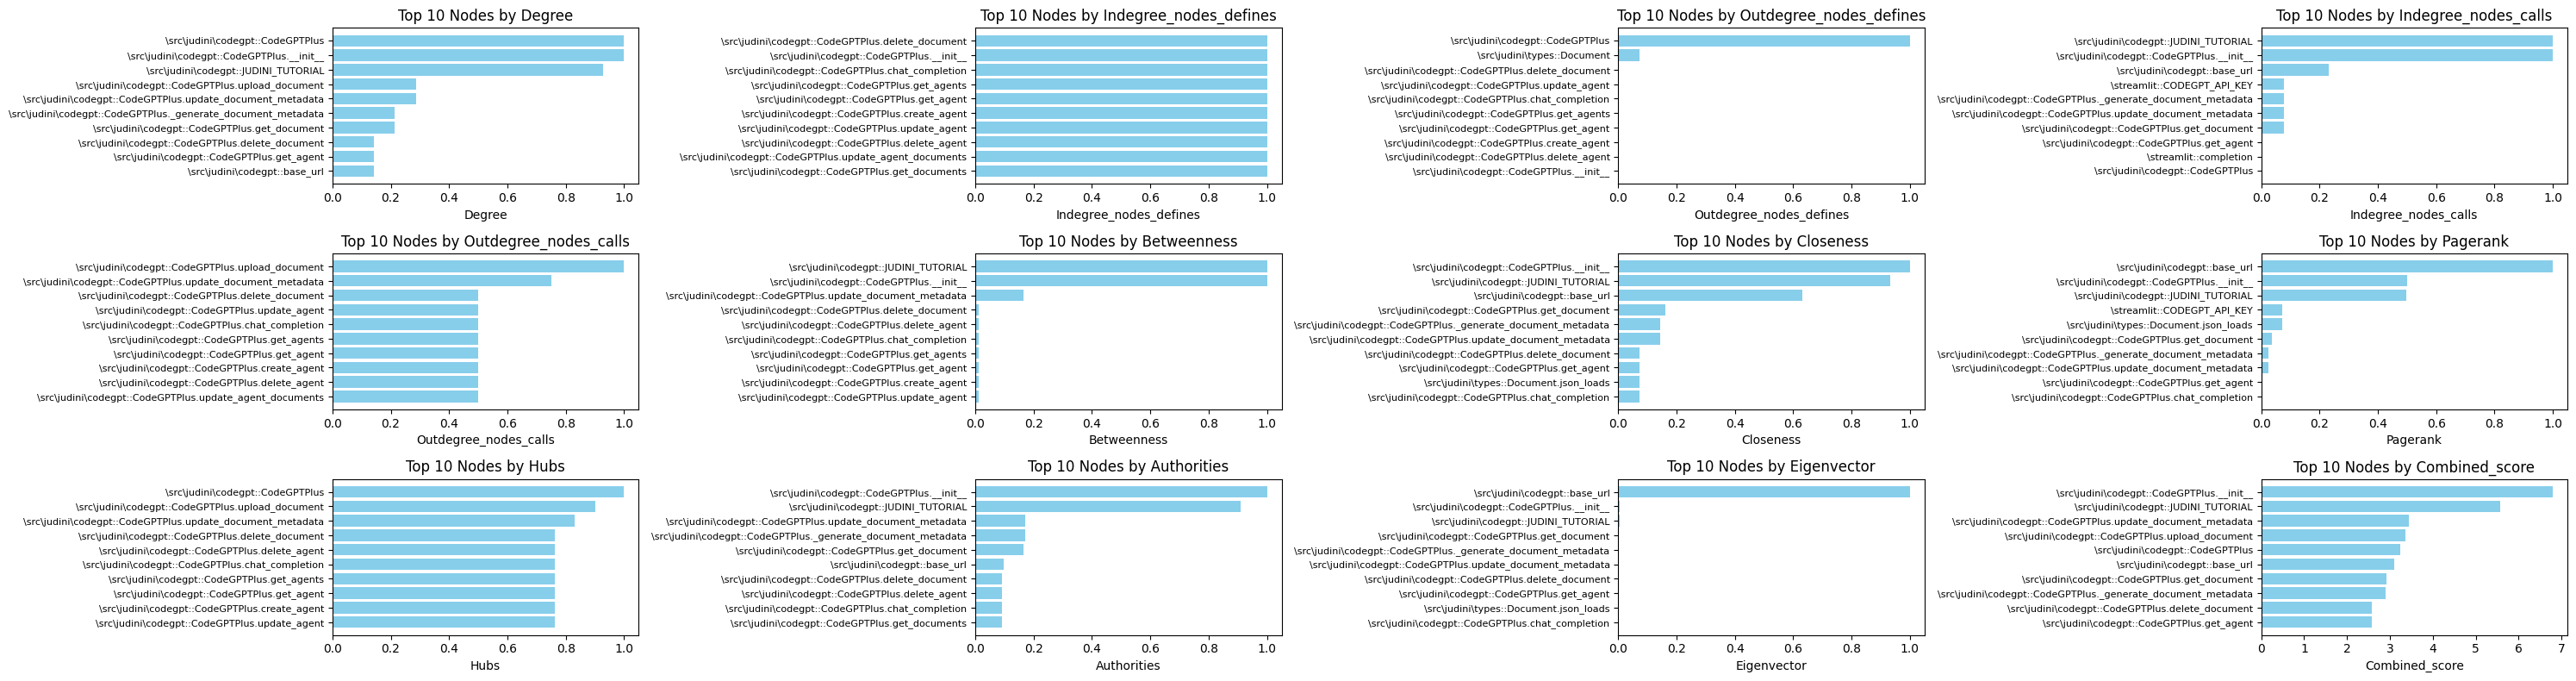

In [42]:

# Metrics to plot
metrics_nodes = ['degree', "indegree_nodes_defines", "outdegree_nodes_defines","indegree_nodes_calls", "outdegree_nodes_calls",'betweenness', 'closeness', 'pagerank', 'hubs', 'authorities', 'eigenvector',"combined_score"]

# Create a figure for nodes
fig_nodes, axs_nodes = plt.subplots(nrows=3, ncols=4, figsize=(30, 8))

axs_nodes = axs_nodes.flatten()

# Plotting each metric for top 10 nodes
for i, metric in enumerate(metrics_nodes):
    top_10_nodes = df_nodes.sort_values(by=metric, ascending=False).head(10)
    
    # Plotting top 10 nodes
    axs_nodes[i].barh(top_10_nodes.index, top_10_nodes[metric], color='skyblue')
    axs_nodes[i].set_xlabel(metric.capitalize())
    axs_nodes[i].set_title(f'Top 10 Nodes by {metric.capitalize()}')
    axs_nodes[i].invert_yaxis()  # To display the highest centrality at the top
    axs_nodes[i].tick_params(axis='y', labelsize=8)

fig_nodes.tight_layout()
plt.show()

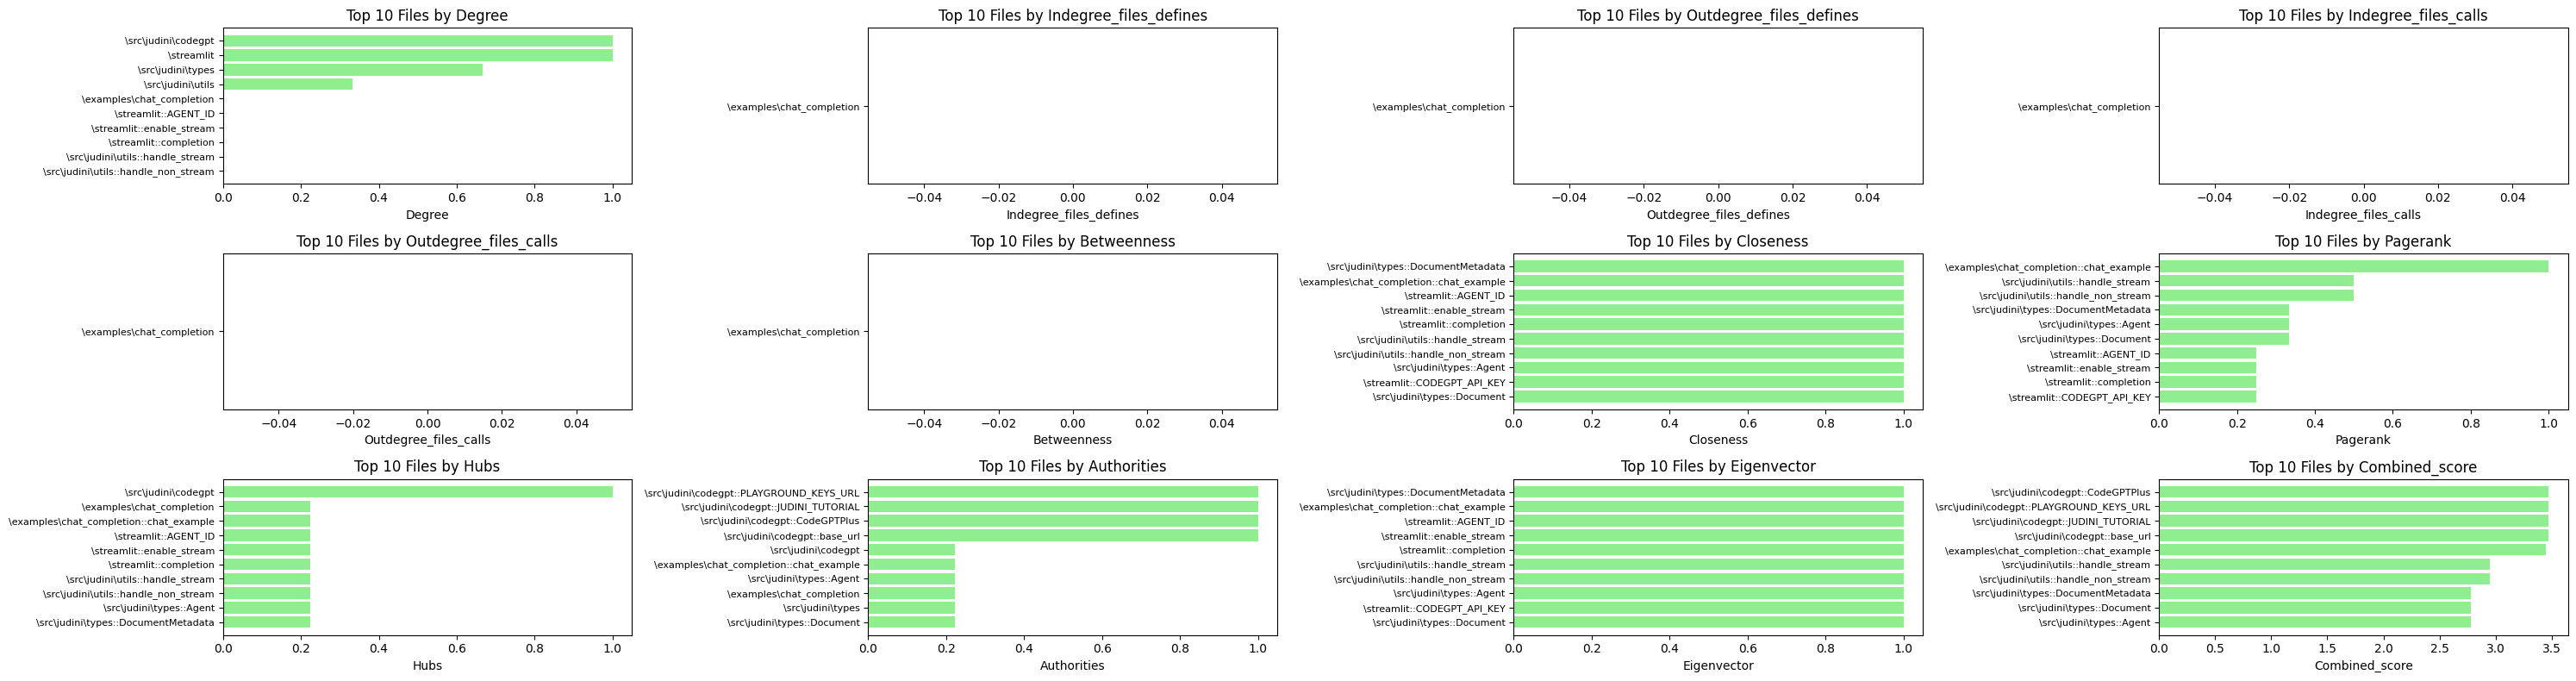

In [43]:
metrics_files = ['degree', "indegree_files_defines", "outdegree_files_defines","indegree_files_calls", "outdegree_files_calls",'betweenness', 'closeness', 'pagerank', 'hubs', 'authorities', 'eigenvector',"combined_score"]

fig_files, axs_files = plt.subplots(nrows=3, ncols=4, figsize=(30, 8))
axs_files = axs_files.flatten()
# Plotting each metric for top 10 files
for i, metric in enumerate(metrics_files):
    top_10_files = df_files.sort_values(by=metric, ascending=False).head(10)
    
    # Plotting top 10 files
    axs_files[i].barh(top_10_files.index, top_10_files[metric], color='lightgreen')
    axs_files[i].set_xlabel(metric.capitalize())
    axs_files[i].set_title(f'Top 10 Files by {metric.capitalize()}')
    axs_files[i].invert_yaxis()  # To display the highest centrality at the top
    axs_files[i].tick_params(axis='y', labelsize=8)

fig_files.tight_layout()
plt.show()